In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-08-01 21:19:22.381998: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 21:19:22.395241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 21:19:22.412782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 21:19:22.412805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 21:19:22.424106: I tensorflow/core/platform/cpu_feature_gua

In [2]:
import torch
#torch.multiprocessing.set_start_method('spawn')
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
import torch.nn.utils as nn_utils
from tqdm import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import NSF2
from gpzoo.utilities import rescale_spatial_coords, dims_autocorr, regularized_nmf, add_jitter, scanpy_sizefactors, deviancePoisson, anndata_to_train_val #init_softplus
import gpzoo.pri_experiment_utilities as exp
import squidpy as sq
import numpy as np
import time
import random
import scanpy as sc
import anndata as ad
from anndata import AnnData
from squidpy.gr import spatial_neighbors, spatial_autocorr
from sklearn.cluster import KMeans
from os import path
from copy import deepcopy
from scipy import sparse
from contextlib import suppress
from scanpy import read_h5ad
from tensorflow import constant
from tensorflow.data import Dataset
import tensorflow as tf
from sklearn.decomposition import NMF

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
import gpzoo.pri_experiment_utilities as putil

In [4]:
random.seed(256)
root_path = '/engelhardt/home/pshrestha/vnngp/'
dpath = path.join(root_path, "data/crc_data")
dtp = "float32"
dpth = path.join(root_path, "data/")
mpth = path.join(root_path, "models/")
rpth = path.join(root_path, "results/")
crc_path = path.join(rpth, "crc/")

In [5]:
print("CUDA available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())
print("Current GPU: ", torch.cuda.current_device())
print("GPU Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available:  True
Number of GPUs:  2
Current GPU:  0
GPU Name:  NVIDIA A30


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
def center_data(Dtr_n,Dval_n=None):
  Dtr_c = deepcopy(Dtr_n)
  feature_means=Dtr_c["Y"].mean(axis=0)
  Dtr_c["Y"] -= feature_means
  if Dval_n:
    Dval_c = deepcopy(Dval_n)
    Dval_c["Y"] -= feature_means
  else:
    Dval_c = None
  return feature_means,Dtr_c,Dval_c

def prepare_datasets_tf(Dtrain,Dval=None,shuffle=False,batch_size=None):
  """
  Dtrain and Dval are dicts containing numpy np.arrays of data.
  Dtrain must contain the key "Y"
  Returns a from_tensor_slices conversion of Dtrain and a dict of tensors for Dval
  """
  Ntr = Dtrain["Y"].shape[0]
  if batch_size is None:
    #ie one batch containing all observations by default
    batch_size = Ntr
  else:
    batch_size = minibatch_size_adjust(Ntr,batch_size)
  Dtrain = Dataset.from_tensor_slices(Dtrain)
  if shuffle:
    Dtrain = Dtrain.shuffle(Ntr)
  Dtrain = Dtrain.batch(batch_size)
  if Dval is not None:
    Dval = {i:constant(Dval[i]) for i in Dval}
  return Dtrain, Ntr, Dval

def scanpy_sizefactors(Y):
  sz = Y.sum(axis=1,keepdims=True)
  return sz/np.median(sz)

In [8]:
def heatmap(X,y,figsize=(6,4),bgcol="gray",cmap="turbo",**kwargs):
  fig,ax=plt.subplots(figsize=figsize)
  ax.set_facecolor(bgcol)
  ax.scatter(X[:,0],X[:,1],c=y,cmap=cmap,**kwargs)
  # fig.show()

In [9]:
name = 'adata_SN048_A121573_Rep2.h5ad'
spath = path.join(dpath, name)
print("vnngp/data/crc_data/adata_SN048_A121573_Rep2.h5ad")
print(spath)

vnngp/data/crc_data/adata_SN048_A121573_Rep2.h5ad
/engelhardt/home/pshrestha/vnngp/data/crc_data/adata_SN048_A121573_Rep2.h5ad


In [10]:
ad = sc.read_h5ad(spath)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
X = np.array(ad.obs[['x_array', 'y_array']])
print(X.shape)

ad.obsm['spatial'] = X

(2291, 2)


In [12]:
Y_sums = np.array(np.sum(ad.X > 0, axis=0))[0]
    
Y = np.array(ad.X[:, Y_sums>100].todense(), dtype=int).T
Y_dense = np.array(ad.X.todense(), dtype=int).T

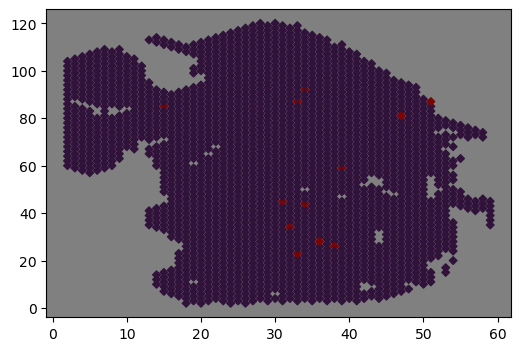

In [13]:
heatmap(X, Y.T[:,0],marker="D",s=15)

In [14]:
ad.var["mt"] = ad.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], inplace=True)
ad = ad[ad.obs.pct_counts_mt < 20]
sc.pp.filter_genes(ad, min_cells=1)
sc.pp.filter_cells(ad, min_counts=100)
ad.layers = {"counts":ad.X.copy()} #store raw counts before normalization changes ad.X
ad.layers = {"counts":ad.X.copy()}

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [15]:
#sc.pp.normalize_total(ad, inplace=True, layers=None, key_added="sizefactor") #normalized total counts per cell to a common value
#sc.pp.log1p(ad) # performs a log transformation to the data

In [16]:
ad.var['deviance_poisson'] = deviancePoisson(ad.layers["counts"])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]

Dtr_n['X'] shape: (2176, 2)
Dtr_n['Y'] shape: (2176, 17022)
Dtr['X'] shape: (2176, 2)
Dtr['Y'] shape: (2176, 17022)


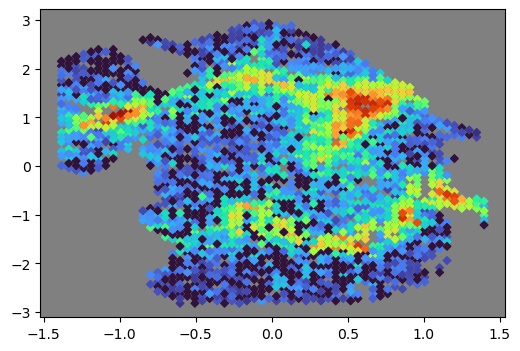

In [17]:
Dtr,Dval = anndata_to_train_val(ad,layer="counts",sz="scanpy")
Dtr_n,Dval_n = anndata_to_train_val(ad) #normalized data

fmeans, Dtr_c, Dval_c = center_data(Dtr_n,Dval_n) #centered features
Xtr = Dtr["X"] #note this should be identical to Dtr_n["X"]
Ntr = Xtr.shape[0]

print(f"Dtr_n['X'] shape: {Dtr_n['X'].shape}")
print(f"Dtr_n['Y'] shape: {Dtr_n['Y'].shape}")

print(f"Dtr['X'] shape: {Dtr['X'].shape}")
print(f"Dtr['Y'] shape: {Dtr['Y'].shape}")

Dtf = prepare_datasets_tf(Dtr,Dval=Dval,shuffle=False)
Dtf_n = prepare_datasets_tf(Dtr_n,Dval=Dval_n,shuffle=False)
Dtf_c = prepare_datasets_tf(Dtr_c,Dval=Dval_c,shuffle=False)

heatmap(Xtr,Dtr_n["Y"][:,0],marker="D",s=15)

In [18]:
Dtr_n["Y"].mean()

0.21028328

In [19]:
Dtr["Y"].mean()

0.21028328

In [20]:
L = [10]
max_iter = 1000
#crc_nmf_path = path.join(crc_path, "nmf")

In [21]:
Dtr_n["Y"].shape

(2176, 17022)

In [22]:
Y.shape

(12190, 2291)

In [62]:
nmf_model = NMF(n_components=5, max_iter=100, init='random', random_state=0, alpha_H=2e-1, alpha_W=1e-7)

In [63]:
nmf_model.fit(Dtr_n["Y"])

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.2, alpha_W=1e-07, init='random', max_iter=100, n_components=5,
    random_state=0)

In [64]:
exp_factors = nmf_model.transform(Dtr_n["Y"])
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T

In [65]:
moran_idx, moranI = putil.dims_autocorr(np.exp(factors), Dtr["X"])

In [66]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

In [67]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):
    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
        
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        
        curr_ax = ax[i%5]
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [68]:
len(np.exp(factors_ordered).T)

5

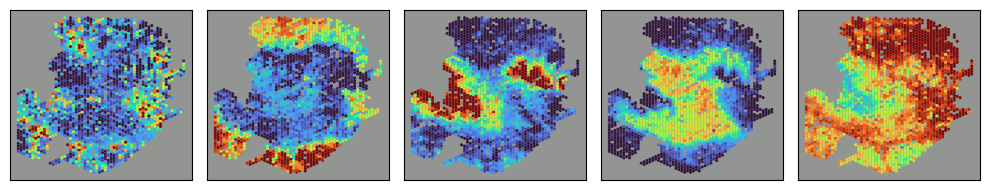

In [69]:
##### Check initialization
size=2
fig, axes = plt.subplots(1, 5, figsize=(size*5, size*1), tight_layout=True)
plot_factors(np.exp(factors_ordered).T, Dtr["X"], moran_idx=None, size=2, s=1.5, alpha=0.9, ax=axes)

In [70]:
factors.shape

(2176, 5)

In [73]:
L = [10]
#M = [1000, 2000]
M = [2000]
#K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
K = [8]
S = [0.2, 0.5, 1.0, 2.0]
LS = [0.1, 0.2]
lkzz_builds = [1]

In [74]:
def build_model(X, Y, loadings=None, factors=None, model_type=None, **kwargs):
    """
    Parameters:
    X:
        - torch.Size([N, D])
    Y:
        - torch.Size([L, N])
    loadings:
        - torch.Size([L, K])
    factors:
        - torch.Size([N, L])
    """
    V = scanpy_sizefactors(Y.T)
    #X = torch.tensor(X).type(torch.float).to(device)
    #Y = torch.tensor(Y).type(torch.float).to(device)
    kwargs = kwargs['kwargs']

    kmeans = putil.inducing_points_cluster_centers(X, kwargs['M'], random_state=kwargs['rs'])
    Z = nn.Parameter(torch.tensor(kmeans.cluster_centers_).type(torch.float))
    kernel = NSF_RBF(L=kwargs['L'], sigma=kwargs['sigma'], lengthscale=kwargs['lengthscale'])
    
    gp = None
    if model_type == 'VNNGP':
        gp = VNNGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'], K=kwargs['K'])
    elif model_type == 'SVGP':
        gp = SVGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'])

    X = torch.tensor(X).type(torch.float)
    Y = torch.tensor(Y).type(torch.float)
    Kzx = kernel.forward(Z.to('cpu'), X.to('cpu'))
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z)

    all_factors = torch.tensor(factors.T)[:, :, None].type(torch.float)
    #print(Kzx @ Kxz)
    L1 = torch.linalg.cholesky(add_jitter(Kzx @ Kxz, 1e-1)) # changed from 1e-4 to 1e-3
    
    solved1 = torch.cholesky_solve(Kzx @ all_factors, L1)
    mu = (Kzz @ solved1).to(device)
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
    Lu = 1e-2 * torch.eye(kwargs['M']).expand(kwargs['L'], kwargs['M'], kwargs['M'])
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    model = NSF2(gp=gp, y=Y, L=kwargs['L'])

    if loadings is not None:
        model.W = nn.Parameter(torch.tensor(putil.init_softplus(loadings)[:, :kwargs['L']]).type(torch.float))
    model.V = nn.Parameter(torch.squeeze(torch.tensor(putil.init_softplus(V)).type(torch.float)))
    model.to(device)
    return model

In [86]:
L = [10]
M = [3000]
#K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#K = [1, 5, 10, 20]
K = [8]
lkzz_builds = [1]
#sigmas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sigmas = [1.0]
lengthscales = [0.1]

In [87]:
steps = 3000
model_type = 'VNNGP'
batched = True
save_path = path.join(root_path, "results/crc/nnnsf")

In [88]:
X = torch.tensor(Dtr["X"], dtype=torch.float)
Y = torch.tensor(Dtr["Y"].T, dtype=torch.float)

/tmp/ipykernel_3248056/2130726119.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.float)
/tmp/ipykernel_3248056/2130726119.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y).type(torch.float)
/tmp/ipykernel_3248056/2130726119.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float).to(device)
/tmp/ipykernel_3248056/2130726119.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor

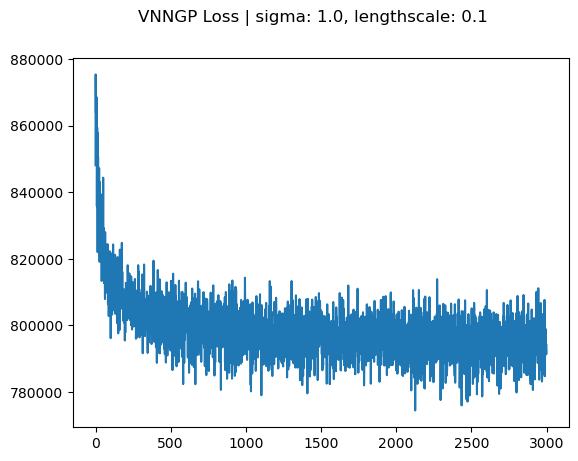

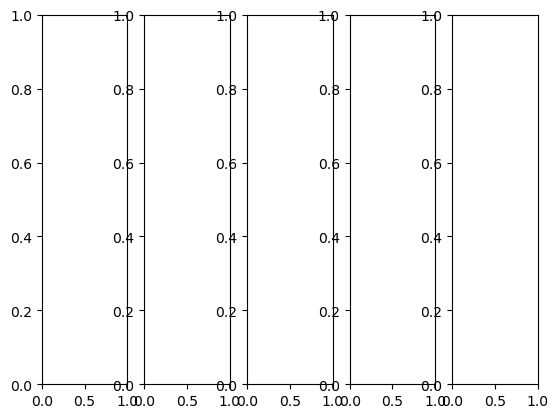

In [89]:
for k in K:
    for s in sigmas:
        for l in lengthscales:
            dicts = {
                'L': 5, 
                'M': 2176, 
                'K': 8,
                'sigma': s, 
                'lengthscale': l, 
                'jtr': 1e-1,
                'batch_size': 128,
                'lr': 1e-3,
                'rs': 256,
                'lkzz_build': 1,
            }
            
            factors = np.array(factors)
            loadings = np.array(loadings)
            
            kwargs = dicts
            file_path = model_type
            #X, Y = data_func()
            #K=None
            if model_type == 'VNNGP':
                file_path += f"_K={kwargs['K']}"
            
                if kwargs['lkzz_build']:
                    file_path += f"_lkzz={kwargs['lkzz_build']}"
                    
            file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_iter={steps}"
            if batched:
                file_path += f"_bs={kwargs['batch_size']}"
                
            if NMF:
                # with NMF initialization
                file_path += f"_NMFinit"
                X_array = np.array(X.cpu())
                Y_array = np.array(Y.cpu())
                moran_idx, moranI = putil.dims_autocorr(factors, X_array)
                factors=factors[:, moran_idx]
                loadings=loadings[:, moran_idx]
                model = build_model(X_array, Y_array, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
                    
            #model = build_model(X, Y, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
            putil.model_grads(model)
            model.prior.jitter=kwargs['jtr']
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
                
            model.to(device)
            X = torch.tensor(X).type(torch.float)
            Y = torch.tensor(Y).type(torch.float)
            X_train = X.to(device)
            #Y_train = Y.to(device)
                
            start_time = time.time()
            X = torch.tensor(X, dtype=torch.float).to(device)
            Y = torch.tensor(Y, dtype=torch.float).to(device)
            losses, means, scales, idxs = putil.train_batched(model, optimizer, X_train, Y, device,
                                                        steps=steps, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)
            end_time = time.time()
                
            final_time = end_time - start_time
                
            torch.save(model.state_dict(), f'{save_path}/{file_path}_state_dict.pth')
            torch.save({'losses': losses,
                        'means': means,
                        'scales': scales,
                        'time': final_time},
                         f'{save_path}/{file_path}_model.pt')
            
            #print('sigmas:', model.prior.kernel.sigma)
            #print('lengthscale:', model.prior.kernel.lengthscale)
            
            fig, ax = plt.subplots()
            ax.plot(losses)
            fig.suptitle(f"{model_type} Loss | sigma: {kwargs['sigma']}, lengthscale: {kwargs['lengthscale']}")
            plt.show()
            #fig.savefig(f'{save_path}/{file_path}_loss.png')
            #fig.close()
            
            #size=2
            #fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
                
            model.cpu()
            qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
            mean = torch.exp(qF.mean).detach().numpy()
            #plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1.2, alpha=0.9, ax=axes)

            plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=None, size=2, s=1.2, alpha=0.9, ax=axes)
            fig.suptitle(f'Factors | sigma: {kwargs["sigma"]}, lengthscale: {kwargs["lengthscale"]}')
            #fig.savefig(f'{save_path}/{file_path}_plot.png')
            #fig.close()

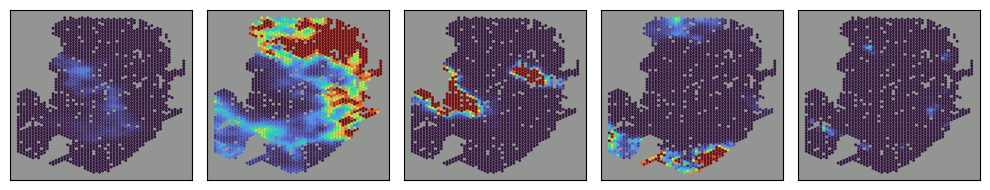

In [92]:
size=2
fig, axes = plt.subplots(1, 5, figsize=(size*5, size*1), tight_layout=True)
plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1.2, alpha=0.9, ax=axes)
                
#model.cpu()
#qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
#mean = torch.exp(qF.mean).detach().numpy()
#plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1.2, alpha=0.9, ax=axes)
#fig.suptitle(f'Factors | sigma: {kwargs["sigma"]}, lengthscale: {kwargs["lengthscale"]}')
#fig.savefig(f'{save_path}/{file_path}_plot.png')

In [61]:
save_path = path.join(root_path, "results/crc/nnnsf")
Dtr["X"] = torch.tensor(Dtr["X"], dtype=torch.float)
Dtr["Y"] = torch.tensor(Dtr["Y"], dtype=torch.float)
iter = 100

#outputs_dict = defaultdict(list)
for l in L:
    for m in M:
        for k in K:
            for lk in lkzz_builds:
                file_path = path.join(save_path, f"VNNGP_K={k}_lkzz={lk}_M={m}_L={l}_lr=0.001_jtr=0.01_iter={iter}_bs=128_NMFinit_state_dict.pth")
                if not path.isfile(file_path):
                    print(f"{file_path} does not exist. Running the code...")
                    dicts = {
                            'L': l, 
                            'M': m, 
                            'K': k,
                            'sigma': 0.1, 
                            'lengthscale': 0.07, 
                            'jtr': 1e-2,
                            'batch_size': 128,
                            'lr': 1e-3,
                            'rs': 256,
                            'lkzz_build': lk,
                    }
                    nmf_path = path.join(root_path, f"results/crc/nmf/nmf_factors_iter=1000_rs=256_L={dicts['L']}.pt")
                    exp.run_validation_experiment(Dtr["X"], Dtr["Y"].T, save_path, steps=iter, batched=True,
                                     model_type='VNNGP', NMF=True, nmf_path=nmf_path, kwargs=dicts)
                    plt.close('all')
                else:
                    print(f"{file_path} exists. Skipping the code.")
    

#nmf_path = f"./results/nmf/nmf_factors_iter=1000_rs=256_L={dicts['L']}.pt"
#nmf_path = f"./visium_final/nmf/nmf_factors_iter=500_rs=256_L={dicts['L']}.pt"

/engelhardt/home/pshrestha/vnngp/results/crc/nnnsf/VNNGP_K=8_lkzz=1_M=3000_L=10_lr=0.001_jtr=0.01_iter=100_bs=128_NMFinit_state_dict.pth does not exist. Running the code...


ValueError: n_samples=2176 should be >= n_clusters=3000.

In [ ]:
model.cpu()
qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()
plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=0.2, alpha=0.9, ax=axes)
fig.suptitle(f'Factors | sigma: {kwargs["sigma"]}, lengthscale: {kwargs["lengthscale"]}')
fig.savefig(f'{save_path}/{file_path}_plot.png')
#fig.close()

In [1]:
print(Dtr['X'].shape)
print((Dtr['Y'].T).shape)

NameError: name 'Dtr' is not defined